---
title: "DSAN 5000 HW 4.1: Topic Modeling"
format:
  html:
    toc: true
    embed-resources: true
    df-print: kable
    link-external-newwindow: true
    link-external-icon: true
---

Welcome to HW4! In this first part, you will gain hands-on experience with how **PCA** can be used to automatically (i.e., in an **unsupervised** manner) infer a set of general semantic **topics** from a corpus of plaintext documents. Specifically, you will use a technique called [**Non-Negative Matrix Factorization**](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization), which is a modification/extension of the basic PCA algorithm that usually gives better results for non-negative data: that is, data like the non-negative counts in the **document-term matrix** you will construct in this part!

## Step 1: Imports and Global Configuration

Here, as a technique that can be helpful for you when building **pipelines** (as opposed to single notebooks or single self-contained `.py` files), let's load a global **configuration file** using Python's built-in `configparser` library.

By running the following code cell, you can see how it enables us to store and use a set of **global variables** within a file called `hw4.ini`, which we'll use across the different notebooks in this homework. Specifically, the following loads `hw4.ini` then prints out the value of the `nyt_corpus` global variable, which we'll use below as the URL we'll download the corpus from.

In [1]:
#| label: hw4-1-import-configparser
import configparser
config = configparser.ConfigParser()
config.read("hw4.ini")
nyt_corpus_url = config.get('ExternalFiles', 'nyt_corpus')
print(nyt_corpus_url)

https://github.com/jpowerj/dsan-content/raw/refs/heads/main/2024-fall-dsan5000/hw4/nyt_01-2007_balanced.csv.zip


Now, you can run the following code cell to import the remaining libraries we'll need.

In [2]:
#| label: hw4-1-imports
# For serializing (saving) our trained scikit-learn models to disk
import pickle
# Contains a constant string.punctuation that will help with text cleaning!
import string

# For storing our data in DataFrames
import pandas as pd
# NumPy arrays are the main format accepted by scikit-learn
import numpy as np
# CountVectorizer and TfidfVectorizer can both be used to transform a corpus
# of text into a Document-Term Matrix; here we'll use TfidfVectorizer since it
# allows us to extract more useful information for a small (N = 800) corpus
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# LatentDirichletAllocation and NMF (for Non-Negative Matrix Factorization) are
# two popular algorithms used for topic modeling; here we'll use NMF since it is
# more closely related to the PCA approach learned in class
from sklearn.decomposition import LatentDirichletAllocation, NMF
# For plotting a confusion matrix of our predictions in Step 9
from sklearn.metrics import ConfusionMatrixDisplay

# For visualizing topics at the end of the assignment
import matplotlib.pyplot as plt

## Step 2: Load and Clean Documents

Run the following code cell to load the data and display the first 5 rows.

::: {.callout-tip title="SSL Errors"}

If you encounter an error that looks like:

```
URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1020)>
```

This comes from the fact that Python on Mac doesn't seem to come with a set of certificates needed to load files over HTTPS (as opposed to HTTP). You should be able to resolve this by installing these certificates as explained in the first answer to [this StackOverflow question](https://stackoverflow.com/q/52805115/3721846), then restarting your kernel.

If you're unable to resolve this, however, you can also download the csv directly into your working directory via [this link](https://github.com/jpowerj/dsan-content/raw/refs/heads/main/2024-fall-dsan5000/hw4/nyt_01-2007_balanced.csv.zip).

In [3]:
#| label: hw4-1-load-corpus
art_df = pd.read_csv(nyt_corpus_url)
art_df.head()


,id,section,text_raw
0,01/29/1822411.xml,Arts,Scott Colley ''Architect of the Silent Moment...
1,01/24/1821160.xml,Arts,Greece Seeks Cancellation of Christie's Auctio...
2,01/10/1817850.xml,Arts,"Jim Caviezel, below, will do a reprise of his ..."
3,01/31/1822716.xml,Arts,"Forgive that older gentleman in Malibu, Calif...."
4,01/09/1817611.xml,Arts,General managers of opera companies tend to be...


Run the following code cell as well, which shows that we have a **balanced corpus**, consisting of 200 articles sampled from each of the four sections we're interested in: Arts, Sports, US, and World

In [4]:
#| label: hw4-1-section-counts
art_df['section'].value_counts()

section
Arts      200
Sports    200
US        200
World     200
Name: count, dtype: int64

Your job is now to take this balanced corpus and **clean** each article. Your code should take the article texts contained in the column `raw_text` and transform it into a new column called `cleaned_text` with the following cleaning steps applied:

1. Remove any **digits** found in the articles. Here note that `str` objects in Python come with a built-in `.isdigit()` function
2. Remove any **punctuation characters** found in the articles. Here, you can use the object `string.punctuation` from Python's `string` library, which looks as follows:

In [5]:
#| label: hw4-1-punctuation-list

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

3. **Lowercase** every letter in the articles. Here, you can use the `.lower()` function available on all `str` objects in Python
4. Remove **stopwords** from the article. Here, you should use the `nltk` library which provides a pre-constructed list of English stopwords. However, you should add four additional stopwords to the default NLTK list:
    * Since the NY Times' style guide specifies that political leaders should be addressed as "Mr.", "Ms.", or "Mrs.", the stopwords `"mr"`, `"ms"`, and `"mrs"` should be added.
    * Since the digitization of these articles sometimes resulted in a typo where "the" was digitized as `"th"`, the stopword `"th"` should be added as well.

*(If you have trouble trying to get the stopwords from NLTK, or if you find loading from a `.txt` file easier, we have also included the default NLTK english stopwords in this repository, with filepath `./data/nltk_stopwords_en.txt`)*


So, in the following code cell:

* Load the default English stopword list from `nltk`, then add the stopwords specified in `stopwowrds_custom` list defined at the beginning of the cell, to produce a list of stopwords named `stopword_en`. Then
* Complete the provided `clean_article()` function, implementing the four steps described above, and finally
* Use `apply()` to run this function on each entry in the `text_raw` column of `art_df`, producing a new `text_cleaned` column containing the cleaned versions of each article.

In [6]:
#| label: hw4-1-2-response
# Add our own custom stopwords
stopwords_file_path = '/Users/zp/hw-4-zp199717/data/nltk_stopwords_en.txt'
with open(stopwords_file_path, 'r') as file:
    stopwords_en = set(file.read().splitlines())

stopwords_custom = [
    # Biases results to some extent, due to NYTimes style guide using
    # "Mr.", "Ms.", and "Mrs." in US and World News sections only
    "mr", "ms", "mrs",
    # Most common typo/OCR error: "the" -> "th"
    "th"
]
stopwords_custom = stopwords_en.union(stopwords_custom)

def clean_article(text):
    # Your code here
    text = ''.join([char for char in text if not char.isdigit()])
    text = ''.join([char for char in text if char not in string.punctuation])
    text = text.lower()
    words = text.split()
    cleaned_text = ' '.join([word for word in words if word not in stopwords_custom])
    
    return text 

art_df['text_cleaned'] = art_df['text_raw'].apply(clean_article)

art_df.head()


,id,section,text_raw,text_cleaned
0,01/29/1822411.xml,Arts,Scott Colley ''Architect of the Silent Moment...,scott colley architect of the silent moment ...
1,01/24/1821160.xml,Arts,Greece Seeks Cancellation of Christie's Auctio...,greece seeks cancellation of christies auction...
2,01/10/1817850.xml,Arts,"Jim Caviezel, below, will do a reprise of his ...",jim caviezel below will do a reprise of his ro...
3,01/31/1822716.xml,Arts,"Forgive that older gentleman in Malibu, Calif....",forgive that older gentleman in malibu calif i...
4,01/09/1817611.xml,Arts,General managers of opera companies tend to be...,general managers of opera companies tend to be...


## Step 3: Serialize Cleaned Documents

Now that we have cleaned versions of each article, we should **save** this version of the corpus to disk, since we'll use the cleaned versions in future parts of the homework as well.

Though we now have two separate text columns (`text_raw` and `text_cleaned`), we only kept the `text_raw` column so we could see the effect of our cleaning code on the original articles. So, in the following code cell, **drop** the `text_raw` column (in order to reduce disk space) before saving to a file, which you should save to the filepath `./data/nyt_01-2007_cleaned.csv.zip`.

::: {.callout-tip title="Compressed Saving and Loading in Pandas"}

One nice feature in Pandas, when working with text data, is that the `read_csv()` and `to_csv()` functions can save and load **compressed** `.csv.zip` files just as easily as they save and load regular `.csv` files. So, in this assignment, to ensure small file sizes that won't exceed GitHub's file size limits, we'll save and load our DataFrames in compressed `.csv.zip` format.

:::

In [7]:
#| label: hw4-1-3-serialize
cleaned_corpus_fpath = config.get('DataPaths', 'cleaned_corpus_fpath')
print(f"Saving to {cleaned_corpus_fpath}...")
# Your code here
art_df = art_df.drop(columns=['text_raw'])
art_df.to_csv("./data/nyt_01-2007_cleaned.csv.zip")

Saving to ./data/nyt_01-2007_cleaned.csv.zip...


## Step 4: Construct the Document-Term Matrix

For this step you will use `scikit-learn`'s `TfidfVectorizer` class to convert our corpus (the `text_cleaned` column within `art_df`) into a **Document-Term Matrix**.

You can read the Wikipedia article for full details on the [`tf-idf` score](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which stands for "Text Frequency-Inverse Document Frequency" score, but the gist is: for smaller corpora like the 800-document corpus we're using here, the `tf-idf` score essentially just takes the **counts** that would be produced by `scikit-learn`'s `CountVectorizer`, then **downweights** the counts for tokens which appear frequently across **all** of the documents in the corpus. Mathematically, this looks like:

$$
\begin{align*}
\text{tf}(t) &= \frac{\text{Count of token }t\text{ in document}}{\text{Total number of tokens in document}} \\[1em]
\text{df}(t) &= \frac{\text{Number of documents containing token }t}{\text{Total number of documents in corpus}} \\[1em]
\text{idf}(t) &= \frac{1}{\text{df}(t)} \\[1em]
\text{tfidf}(t) &= \text{tf}(t) \cdot \log(\text{idf}(t))
\end{align*}
$$

*(Note: Confusingly, many textbooks refer to the **log** of the inverse document frequency as just "inverse document frequency". I've tried to make this difference explicit by including the $\log()$ term in the final $\text{tfidf}()$ equation above, but (for example) in the Wikipedia article the $\text{idf}()$ function itself is defined to be in log space. You don't need to worry about any of this in your code, since `scikit-learn` will apply the correct formula!)*

In the following cell, please create a `TfidfVectorizer` object named `vectorizer`. The `TfidfVectorizer` should be constructed using the following two hyperparameter values (which are based on common default settings):

* `min_df = 0.01`: This tells `scikit-learn` to drop any words which appear in **less than 1% of all documents**. This is helpful because it removes terms which are so rare (i.e., unique to only one or a few articles) that they won't help us with our goal of **comparing** greater and lower frequencies of words **between** articles.[^1]
* `max_df = 0.5`: This tells `scikit-learn` to drop any words which appear in **more than 50% of all documents**. This helps us for the opposite reason as `min_df`: it removes terms which are so common that they probably do not contain enough semantic information to help us distinguish topics.
    * For example, even if we hadn't removed stopwords above, tokens like `"the"` or `"but"` would still be filtered out due to this setting, since they both probably appear in more than 50% of articles.

[^1]: This is the theoretical reason for using `min_df`, though in practice using `tf-idf` scores handles this issue to a large extent. `min_df` is still important here, however, because of our "downstream task" of estimating topics: basically, because of the way topics are estimated (that is, because of the particular objective function they optimize), without `min_df` you will often find that one of your inferred topics is just a collection of all the rare words in the corpus, rather than a coherent semantic topic. In our case, therefore, setting `min_df` above the default `0.0` value ensures that all four of our inferred topics are semantically meaningful.

In [8]:
#| label: hw4-1-define-vectorizer
# Your code here
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.5)


Now, in the following code cell, use the `vectorizer` object to construct a **Document-Term Matrix** called `dtm` for the corpus. In the last line of the code cell, use `dtm.shape` to display the shape of the constructed DTM. It should have one **row** per document and one **column** per word in the vocabulary (after applying the cleaning and filtering steps).

In [9]:
#| label: hw4-1-4-response
# Your code here
dtm = vectorizer.fit_transform(art_df['text_cleaned'])
dtm.shape

(800, 4951)

## Step 5: Extract Word Weights

While we won't use these total word weights in this part, they will become important in the remaining portions of the homework, so to avoid saving the entire Document-Term Matrix to disk, here we instead just extract the **total tf-idf score** for each word. Since each **column** of the Document-Term Matrix represents a word, this boils down to computing **one number per column** (the sum of the column). And, since the tf-idf score is essentially an importance-weighted version of the raw counts, you can think of these column totals as importance-weighted versions of the **total word counts** across all documents in the corpus.

So, given this, in the following code cell use `vectorizer` and `dtm` to construct a Pandas `DataFrame` called `weight_df`, where each row is a **word** from the vocabulary and the two columns are:

* `word`: The text string of the word from the vocabulary
* `weight`: The **total** tf-idf weight for this word, derived from `dtm`

The first five rows of this `weight_df` object, for example, should look something like the following (the numbers may not match the values you obtain!)

| id | word | count |
| - | - | - |
| 0 | `abandon` | 0.280692 |
| 1 | `abandoned` | 0.939275 |
| 2 | `abbas` | 1.789751 |
| 3 | `abc` | 4.104717 |
| 4 | `ability` | 1.693028 |

Finally, once `weight_df` has been constructed, save it to a file with the filepath given by the global variable `word_weights`, loaded from the `DataPaths` section of `hw4.ini` (see the Step 1 code cell for an example of how to use the `config` object to obtain this value). Note that, since this file is small (under 200KB), we don't need to use Pandas' built-in `.csv.zip` compression here.

In [11]:
#| label: hw4-1-5-response
# Your code here
word_weights = np.array(dtm.sum(axis=0)).flatten()
vocab_words = vectorizer.get_feature_names_out()

weight_df = pd.DataFrame({
    'word': vocab_words,
    'weight': word_weights
})

config = configparser.ConfigParser()
config.read("hw4.ini")
save_it = config.get('DataPaths','word_weights')
weight_df.to_csv(save_it)
weight_df.head()

,word,weight
0,abandon,0.283349
1,abandoned,0.942709
2,abbas,1.731191
3,abc,3.415616
4,ability,1.685223


## Step 6: Dimensionality Reduction with NMF

Now, as we've discussed in class, our life would be easy if we could somehow plot the Document-Term Matrix itself, without any transformations, to visualize whether any "natural" clusters emerge among the words or among the documents. However:

* Viewing the DTM as a collection of **documents** would give us a dataset with 800 observations in a (nearly) 5000-dimensional space, while
* Viewing the DTM as a collection of **words** (i.e., considering the transpose of `dtm`) would give us a dataset with nearly 5000 observations in an 800-dimensional space.

So, in either case, we'll need to use a **dimensionality reduction** technique if we want to visualize our results!

In the following code cell, therefore, please construct a `scikit-learn` `NMF` model named `nmf_model`, with two hyperparameter values:

* `n_components = 4`: This tells `NMF` to estimate **4** topics (i.e., to reduce the dimensionality of our ~5000-dimensional documents down to 4)
* `random_state = 5000`: This seeds the random-number generator for an initial stage of the `NMF` objective function optimization, ensuring comparability between different submissions of the assignment

Then fit the parameters of `nmf_model` to the data (`dtm`), using the `.fit()` function from `scikit-learn`.

In [12]:
#| label: hw4-1-6-response
# Your code here
nmf_model = NMF(n_components=4,random_state=5000).fit(dtm)

Once you have fit the NMF model, the following code provides a `plot_top_words()` function for you, which should display four **word-topic distributions**. These represent, for each estimated topic, the words which are **most likely to appear** in a given chunk of text that is about that topic. So, you should be able to infer from the four plots what each of the four topics is "about" (for example, if art-related words are at the top of the most-likely words list for a given topic, then that topic is probably "about" the arts!), which you will do explicitly in a code chunk below.

The three arguments required by the `plot_top_words()` function are:

* `model`: The `scikit-learn` `NMF` model object
* `word_list`: A list of the words corresponding to the **columns** of the Document-Term Matrix that was inputted to create `nmf_model`. For this argument, note that `TfidfVectorizer` objects have a `.get_feature_names_out()` function, which gives a list of the column headers in the same order as the columns in the resulting DTM!
* `n_top_words`: This argument is optional; if not provided, the function will default to displaying the **top 20 words** for each topic, but you can also use any value you'd like, if you want to display more (or fewer) words per topic.

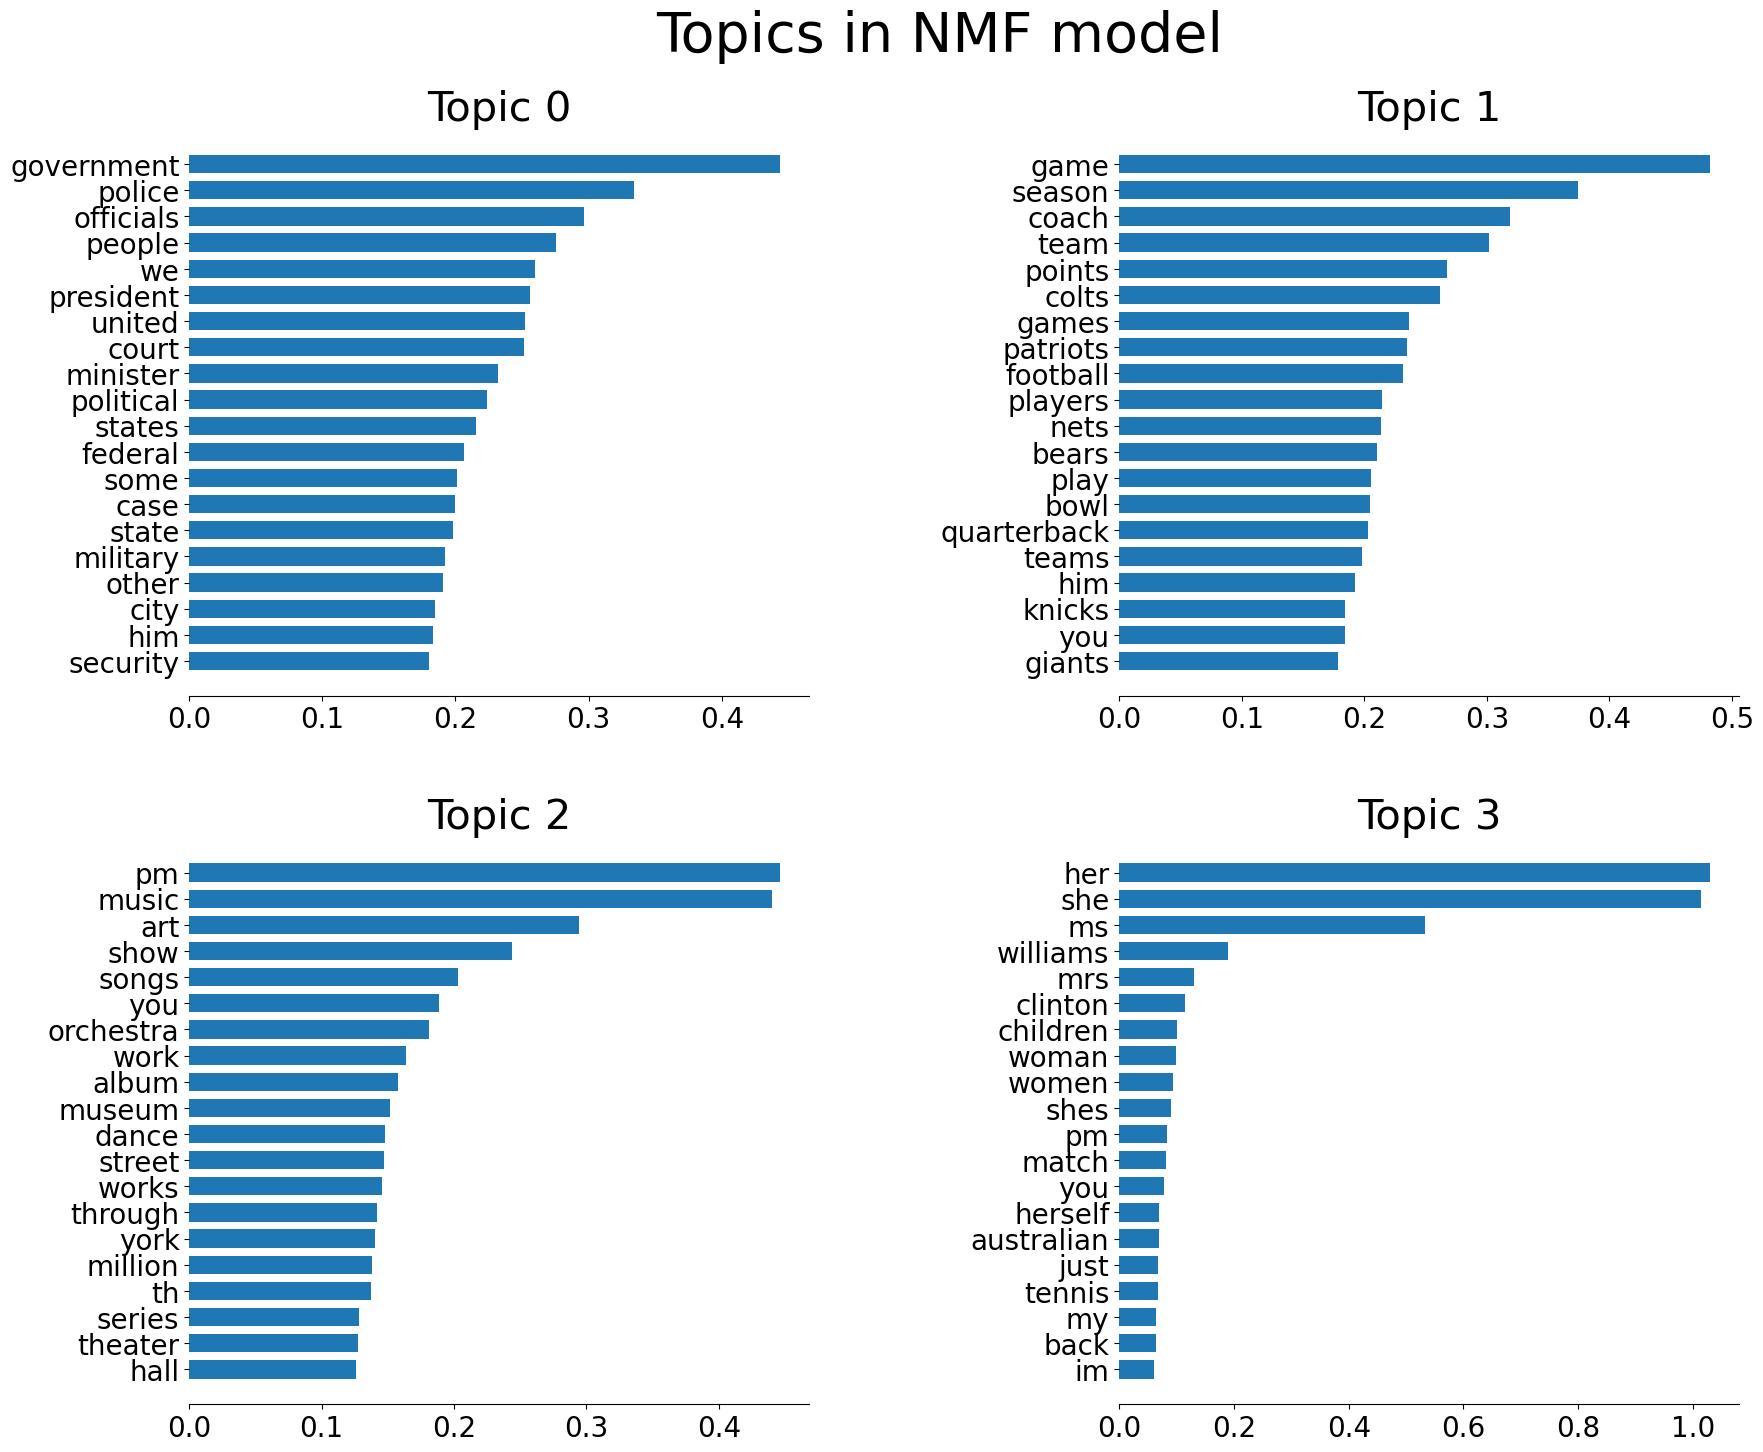

In [13]:
def plot_top_words(model, word_list, n_top_words=20):
    fig, axes = plt.subplots(2, 2, figsize=(20, 15)) #, sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = word_list[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Topics in NMF model", fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.5, hspace=0.25)
    plt.show()

# Your code here (use plot_top_words() to display the distributions of top words
# for the four estimated topics)
plot_top_words(nmf_model,vocab_words)

## Step 7: Assign Meaningful Names to Topics

Now, your job is just to take the above topics and map them to **meaningful** labels: in our case, the meaningful labels would be the original four sections we took the articles from:

* Arts
* Sports
* U.S.
* World

So, in the following code cell, replace the default names assigned to each topic ("Topic 1", "Topic 2", "Topic 3", and "Topic 4") with the *NYT* section that you think the topic might be most closely related to.

In [14]:
#| label: hw4-1-7-response
topic_names = {
    0: "Politics", # Replace with Topic 0 name
    1: "NFL", # Replace with Topic 1 name
    2: "Artwork", # Replace with Topic 2 name
    3: "people", # Replace with Topic 3 name
}
topic_names

{0: 'Politics', 1: 'NFL', 2: 'Artwork', 3: 'people'}

## Step 8: Unsupervised Document Classification

Technically, though the above results would definitely be considered interesting results alone in terms of EDA, we don't yet have a **document classifier**, one of our two original goals. So, in this part, we now will use the topics visualized above to classify documents into one of the four topics.

As a first step, since now we want to plot clusters of **documents** rather than clusters of words (which we visualized above in Step 6), use `scikit-learn`'s `.transform()` function to extract a **Document-Topic Matrix** and name it `doc_topic`. Unlike `dtm`, which had one column per **word**, `doc_topic` should only have 4 columns, representing the degree to which the document is "about" topics 1, 2, 3, and 4. At the end of the code cell, include the line `doc_topic.shape` to verify that `doc_topic` is an $800 \times 4$ matrix.

In [15]:
#| label: hw4-1-8-response
# Your code here
doc_topic = nmf_model.fit_transform(dtm)
doc_topic.shape

(800, 4)

Next, since our goal is to classify each document into a **single** topic, use `NumPy`'s `argmax()` function to find which column contains the **highest** value for each row, storing the result into a `NumPy` array (**not** a matrix) named `argmax_by_row`. Use `argmax_by_row.shape` as the final line in your code cell to verify that you have derive an array with shape `(800,)`.

*(Note that this step is necessary because the original goal of topic modeling was to estimate a **distribution** over topics for each document: for example, if the original document was about [Bo Jackson](https://en.wikipedia.org/wiki/Bo_Jackson), an athlete who achieved success in both professional baseball and professional football, a topic model could infer that 70% of the document focused on his baseball career while 30% of the document focused on his football career. Since our goal is to **classify** rather than estimate a distribution of topics, we therefore use the topic with highest estimated proportion as our classification).*

In [16]:
#| label: hw4-1-8-argmax-by-row
# Your code here
argmax_by_row = np.argmax(doc_topic, axis=1)
argmax_by_row.shape

(800,)

Once you have successfully extracted the topic with greatest emphasis for each document, the following code cell we've provided for you should construct a Pandas `DataFrame` named `doc_topic_df`, where each row represents an article and the `topic_num` column (derived from `argmax_by_row`) has been used to form the string column `topic` (on the basis of the `topic_names` dictionary you created in Step 7 above).

In [17]:
#| label: hw4-1-8-doc-topic-df
if 'argmax_by_row' in globals():
    doc_topic_df = pd.DataFrame(argmax_by_row, columns=['topic_num'])
    doc_topic_df['topic'] = doc_topic_df['topic_num'].apply(lambda x: topic_names[x])
    display(doc_topic_df)



,topic_num,topic
0,2,Artwork
1,2,Artwork
2,2,Artwork
3,2,Artwork
4,2,Artwork
...,...,...
795,0,Politics
796,0,Politics
797,0,Politics
798,0,Politics


Finally, in the following code cell, combine the `art_df` you originally loaded in Step 2 above with the `doc_topic_df` just created, to form a new Pandas `DataFrame` called `prediction_df` (you should be able to just use `pd.concat()` with the `axis=1` argument here, since the order of documents in `art_df` and in `doc_topic_df` should be the same; otherwise, this would require a `join`/`merge` operation!)

Once `prediction_df` has been created, construct a new column named `correct` which is `True` if the inferred topic (the topic in `doc_topic_df`) matches the article's true `section` value from the NY Times. This will allow us to compute the accuracy rate for our automatically-inferred topics (the code included at the end of the code cell), in terms of their ability to reconstruct what section of the NY Times the article was originally published in, without any supervision!

Though in general you should compare accuracy rates with a **baseline model** such as Naïve Bayes, here you can simply compare with **25% accuracy**, since that is the expected number we would get correct by random-guessing between the four topics for each document.

In [18]:
prediction_df = None # Your code here: replace with pd.concat() call
# Your code here (compute 'correct' column)
prediction_df = pd.concat([art_df, doc_topic_df], axis=1)
prediction_df['correct'] = prediction_df['section'] == prediction_df['topic']

if prediction_df is not None and 'correct' in prediction_df.columns:
    prediction_df['correct'].value_counts(normalize=True)

## Step 9: Confusion Matrix

As a more visual way to summarize our classification results, use the [`ConfusionMatrixDisplay` class](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay) from `scikit-learn` to display a 4-by-4 confusion matrix for our four topics: the entry in row $i$ column $j$ should display the number of times topic $j$ was predicted when the true topic was $i$. 

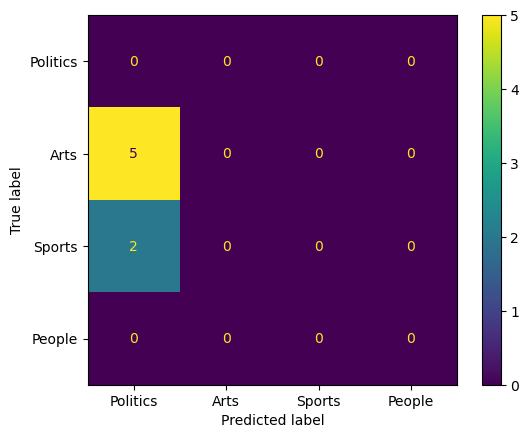

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix = confusion_matrix(prediction_df['section'], prediction_df['topic'], labels=["Politics", "Arts", "Sports", "People"])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Politics", "Arts", "Sports", "People"])
disp.plot()
plt.show()

## Step 10: Serialize the NMF Model

As a final step, please use the following provided code cell to serialize the `nmf_model` to disk, as a file with filepath `./data/nmf_model.pkl`. This will allow us to load it and use it in future steps of the homework.

In [20]:
with open("./data/nmf_model.pkl", "wb") as outfile:
    pickle.dump(nmf_model, outfile, protocol=5)